#### Importing Libraries

In [38]:
# Standard Libraries
from scipy import stats
import pandas as pd
import numpy as np
import pickle
import time

# Visualisation
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # higher resolution plots

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, LassoLars

# Misc
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import warnings
warnings.filterwarnings('ignore')

# Random State #
SEED = 8888

#### Loading Our Data

In [2]:
with open('cleaned_dataset.pickle', 'rb') as f:
    df = pickle.load(f)

In [3]:
df.head()

,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,RoofStyle,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,FireplaceQu,GarageFinish,GarageCars,GarageQual,PavedDrive,YrSold,LogSalePrice,LogLotFrontage,LogLotArea,LogFirstFlrSF,LogGroundArea,MSSubClass_SC160,MSSubClass_SC180,MSSubClass_SC190,MSSubClass_SC20,MSSubClass_SC30,MSSubClass_SC40,MSSubClass_SC45,MSSubClass_SC50,MSSubClass_SC60,MSSubClass_SC70,MSSubClass_SC75,MSSubClass_SC80,...,Exterior2nd_Plywood,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrArea_VnrArea_Small,MasVnrArea_VnrArea_Medium,MasVnrArea_VnrArea_Large,Foundation_CBlock,Foundation_Other,Foundation_PConc,BsmtFinSF1_BsmtSF_Small,BsmtFinSF1_BsmtSF_Medium,BsmtFinSF1_BsmtSF_Large,BsmtFinSF1_BsmtSF_ExtraLarge,2ndFlrSF_SecondFlr_Small,2ndFlrSF_SecondFlr_Medium,2ndFlrSF_SecondFlr_Large,2ndFlrSF_SecondFlr_ExtraLarge,GarageType_BuiltIn,GarageType_Detchd,GarageType_NoGarage,GarageType_Other,WoodDeckSF_WoodDeckSF_Small,WoodDeckSF_WoodDeckSF_Medium,WoodDeckSF_WoodDeckSF_Large,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NoFence,MoSold_Aug,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_Normal,SaleCondition_Other,SaleCondition_Partial
0,0,0,7,5,2003,0,4,3,4,3,1,6,1,150,856,5,1,1,1,0,2,1,3,1,4,8,1,0,2,2,3,1.0,2008,12.247699,4.189655,9.042040,6.753438,7.444249,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1,0,0,6,8,1976,0,3,3,4,3,4,5,1,284,1262,5,1,1,0,1,2,0,3,1,3,6,1,3,2,2,3,1.0,2007,12.109016,4.394449,9.169623,7.141245,7.140453,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
2,1,0,7,5,2001,0,4,3,4,3,2,6,1,434,920,5,1,1,1,0,2,1,3,1,4,6,1,3,2,2,3,1.0,2008,12.317171,4.234107,9.328212,6.825460,7.487734,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
3,1,0,7,5,1915,0,3,3,3,4,1,5,1,540,756,4,1,1,1,0,1,0,3,1,4,7,1,4,1,3,3,1.0,2006,11.849405,4.110874,9.164401,6.869014,7.448334,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,8,5,2000,0,4,3,4,3,3,6,1,490,1145,5,1,1,1,0,2,1,4,1,4,9,1,3,2,3,3,1.0,2008,12.429220,4.442651,9.565284,7.044033,7.695303,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


#### Splitting our Dataset

In [4]:
X = df.drop('LogSalePrice', axis=1)
y = df.LogSalePrice

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X ,y, test_size=0.2, random_state=SEED)

#### Defining Functions

In [44]:
def adj_r_square(X, model_r2):
    '''
    Calculates the adjusted R-Square of the model.
    
    :params:
        X (array): Array of independent variables' values.
        model_r2 (float): R-Square of the model fitted on the same array x as the independent variables.
        
    :returns:
        adj_r2 (float): Adjusted R-Square of the model fitted. 
        
    '''
    n = X[:].size # Number of observations #
    k = X[0].size # Number of parameters # 
    adj_r2 = 1 - (1-model_r2) * ((n-1)/(n-k-1))
    
    return adj_r2

In [49]:
def linear_model_rmse(X, y, cv=5):
    '''
    Function that performs cross validation and returns the RMSE of the training and validation datasets.
    
    :returns:
        training_rmse : List of training RMSE scores.
        validation_rmse : List of validation RMSE scores.
        
    '''
    # Lists to store our results
    training_rmse = []
    validation_rmse = []
    
    training_r2 = []
    validation_r2 = []
    
    training_adj_r2 = []
    validation_adj_r2 = []
    
    # Converting data into ndarrays
    X = np.array(X)
    y = np.array(y)
    
    model = LinearRegression(fit_intercept=True, n_jobs=-1)
    
    kf = KFold(n_splits=cv, shuffle=True, random_state=SEED)
    
    for train_index, valid_index in kf.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_valid, y_valid = X[valid_index], y[valid_index]
        
        model.fit(X_train, y_train)
        
        # Saving RMSE
        train_resid = y_train - model.predict(X_train)
        train_rmse = np.sqrt(np.mean(train_resid**2))
        training_rmse.append(train_rmse)
        
        valid_resid = y_valid - model.predict(X_valid)
        valid_rmse = np.sqrt(np.mean(valid_resid**2))
        validation_rmse.append(valid_rmse)
        
        # Saving R Squared
        train_r_squared = model.score(X_train, y_train)
        training_r2.append(train_r_squared)
        
        valid_r_squared = model.score(X_valid, y_valid)
        validation_r2.append(valid_r_squared)
        
        # Saving Adjusted R Squared
        training_adj_r2.append(adj_r_square(X_train, train_r_squared))
        validation_adj_r2.append(adj_r_square(X_valid, valid_r_squared))
    
    RMSE = {'Training' : training_rmse,
            'Validation' : validation_rmse}
    
    R_Squared = {'Training' : training_r2,
                 'Validation' : validation_r2}
    
    Adj_R_Squared = {'Training' : training_adj_r2,
                     'Validation' : validation_adj_r2}
    
    return RMSE, R_Squared, Adj_R_Squared

In [85]:
def linreg_results_summary(RMSE, R_Squared, Adj_R_Squared):
    print(' '*13, 'Linear Regression Results Summary')
    print('=' * 61)
    print('\t'*2,'Mean RMSE', '\t', 'Mean R^2', '\t', 'Mean Adj R^2')
    
    print('Training',
          '\t', '{:.4f}'.format(np.mean(RMSE['Training'])),
          '\t', '{:.4f}'.format(np.mean(R_Squared['Training'])),
          '\t', '{:.4f}'.format(np.mean(Adj_R_Squared['Training'])))
    
    print('Validation',
          '\t','{:.4f}'.format(np.mean(RMSE['Validation'])),
          '\t', '{:.4f}'.format(np.mean(R_Squared['Validation'])),
          '\t', '{:.4f}'.format(np.mean(Adj_R_Squared['Validation'])))

In [101]:
def lasso_alpha_plots(alphas, X_train, y_train, X_valid, y_valid, fig_size=(6,6), return_series=False):
    '''
    Function that plots the RMSEs of the training and validation datasets across different alpha values for Lasso Regression.
    
    :params:
        alphas : Vector of different alpha values to try. 
        
    '''
    rmse_training = []
    rmse_validation = []
    
    for alpha in alphas:
        lasso_pipe = Pipeline(steps=[('Standardise', StandardScaler()),
                                     ('Lasso', Lasso(alpha=alpha, random_state=SEED))
                                    ])
        model = lasso_pipe.fit(X_train, y_train)
        
        resid_train = y_train - model.predict(X_train)
        rmse_train = np.sqrt(np.mean(resid_train**2))
        rmse_training.append(rmse_train)
        
        resid_valid = y_valid - model.predict(X_valid)
        rmse_valid = np.sqrt(np.mean(resid_valid**2))
        rmse_validation.append(rmse_valid)
        
    rmse_training = pd.Series(rmse_training, index=alphas)
    rmse_validation = pd.Series(rmse_validation, index=alphas)

    # Plotting the RMSE Scores 
    plt.figure(figsize=fig_size)
    plt.title('Training and Validation RMSE over different Alphas')
    
    training_ax = rmse_training.plot(color='blue', grid=True, label='Training RMSE')
    validation_ax = rmse_validation.plot(color='red', grid=True, label='Validation RMSE')
    
    plt.legend(loc='center right')
    plt.show()
    
    if return_series:
        return rmse_training, rmse_validation

In [92]:
def ridge_alpha_plots(alphas, X_train, y_train, X_valid, y_valid, fig_size=(6,6)):
    '''
    Function that plots the RMSEs of the training and validation datasets across different alpha values for Ridge Regression.
    
    :params:
        alphas : Vector of different alpha values to try. 
        
    '''
    rmse_training = []
    rmse_validation = []
    
    for alpha in alphas:
        ridge_pipe = Pipeline(steps=[('Standardise', StandardScaler()),
                                     ('Ridge', Ridge(alpha=alpha, random_state=SEED))
                                    ])
        model = ridge_pipe.fit(X_train, y_train)
        
        resid_train = y_train - model.predict(X_train)
        rmse_train = np.sqrt(np.mean(resid_train**2))
        rmse_training.append(rmse_train)
        
        resid_valid = y_valid - model.predict(X_valid)
        rmse_valid = np.sqrt(np.mean(resid_valid**2))
        rmse_validation.append(rmse_valid)
        
    rmse_training = pd.Series(rmse_training, index=alphas)
    rmse_validation = pd.Series(rmse_validation, index=alphas)

    # Plotting the RMSE Scores 
    plt.figure(figsize=fig_size)
    plt.title('Training and Validation RMSE over different Alphas')
    
    training_ax = rmse_training.plot(color='blue', grid=True, label='Training RMSE')
    validation_ax = rmse_validation.plot(color='red', grid=True, label='Validation RMSE')
    
    plt.legend(loc='center right')
    plt.show()

### Base Model : Linear Regression

In [51]:
linreg_rmse, linreg_score, linreg_adj_score = linear_model_rmse(X_train, y_train)

In [87]:
linreg_results_summary(linreg_rmse, linreg_score, linreg_adj_score)

              Linear Regression Results Summary
		 Mean RMSE 	 Mean R^2 	 Mean Adj R^2
Training 	 0.1019 	 0.9359 	 0.9358
Validation 	 0.1450 	 0.8685 	 0.8679


In [88]:
linreg_rmse

{'Training': [0.1008946096268675,
  0.09797858399427398,
  0.10276900824988268,
  0.10366291991688917,
  0.1044260954104371],
 'Validation': [0.14436562326348357,
  0.18311836604946116,
  0.12987548753316855,
  0.13050226259988285,
  0.13715430534578923]}

In [53]:
linreg_score

{'Training': [0.9375904961833754,
  0.9398631364096985,
  0.9357432071047574,
  0.9332682550582917,
  0.9329683648614795],
 'Validation': [0.8684550370658175,
  0.8047564835492986,
  0.8899693305489523,
  0.8977084693298999,
  0.8814661944480229]}

In [54]:
linreg_adj_score

{'Training': [0.9375231715777804,
  0.9397982634276151,
  0.9356738897256098,
  0.9331962678106112,
  0.9328960541055512],
 'Validation': [0.8678855635008919,
  0.8039112514791248,
  0.8894929948825323,
  0.8972656373024847,
  0.8809530477086402]}

### Lassso Regression Model

#### Finding Optimal Alpha

In [93]:
alpha_vector = 10**np.linspace(-3,2,100)

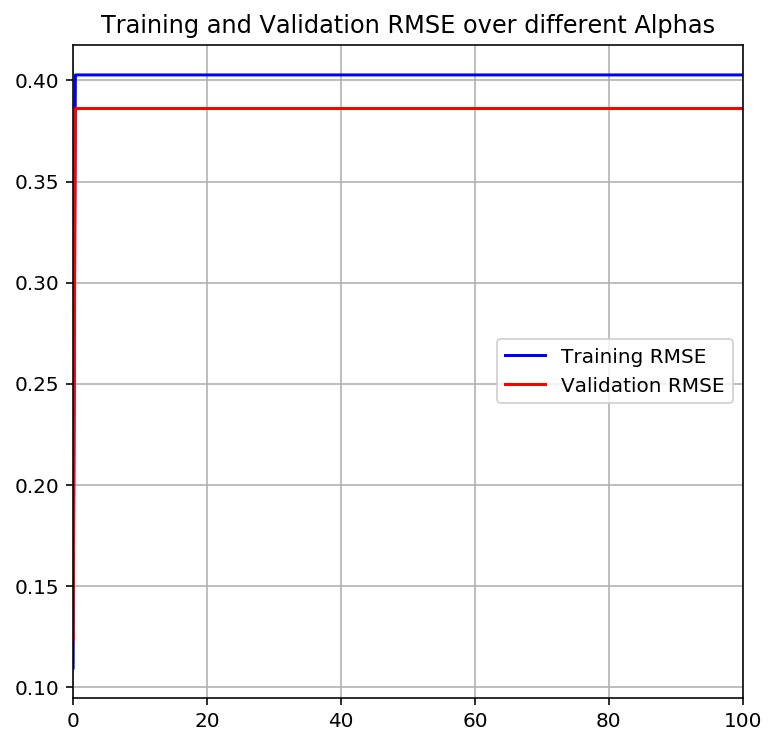

In [94]:
lasso_alpha_plots(alpha_vector, X_train, y_train, X_valid, y_valid)

From the diagram above, it appears that our optimal alpha is very small. Therefore, changing the range of alphas to loop over.

In [95]:
alpha_vector = np.linspace(0,1,101)

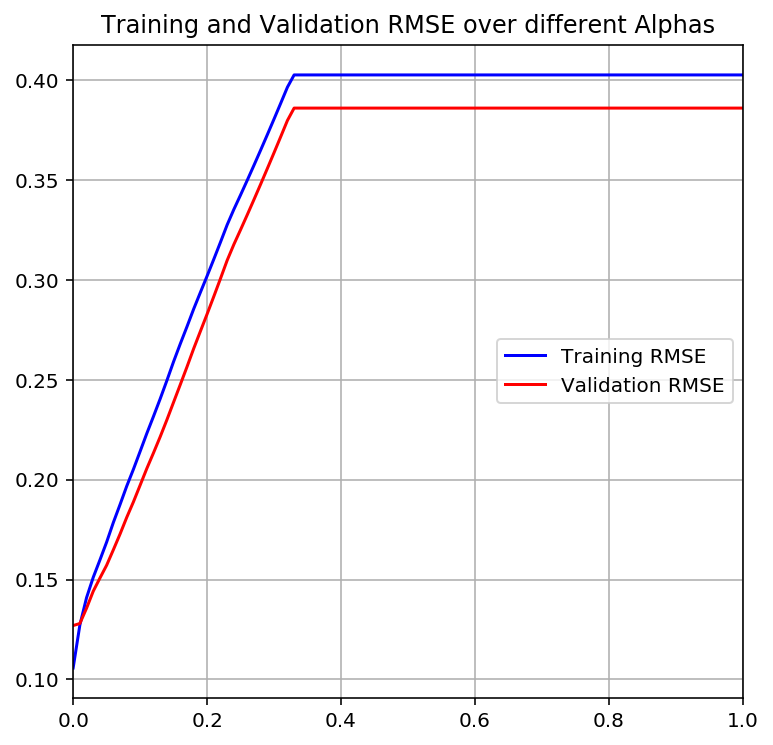

In [96]:
lasso_alpha_plots(alpha_vector, X_train, y_train, X_valid, y_valid)

While the training RMSE appears to increase monotonically before plateauing, there appears to be a minimum point for the validation RMSE. Let's adjust our alpha vector and take a closer look. 

In [97]:
alpha_vector = np.linspace(0,0.1,101)

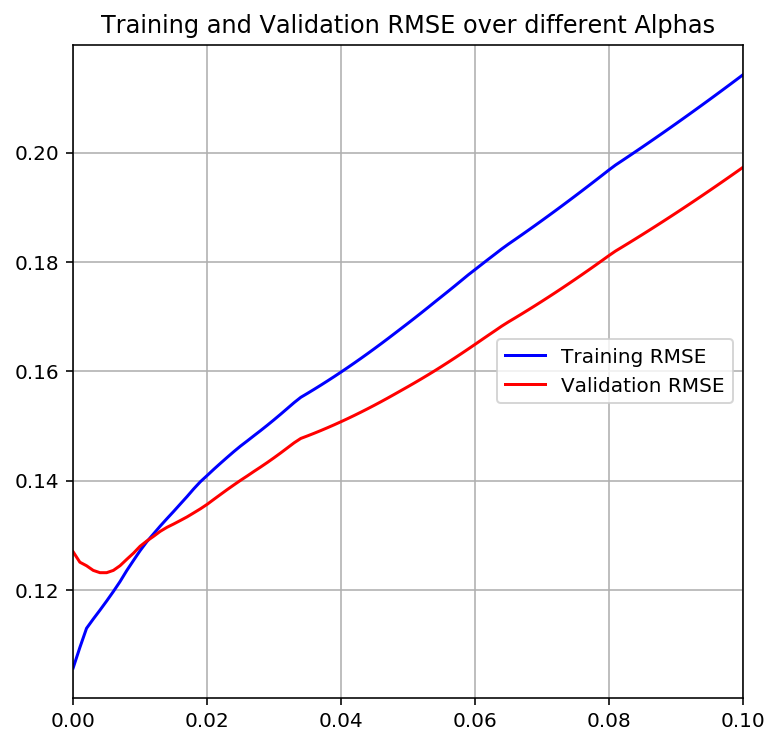

In [104]:
lasso_rmse_train, lasso_rmse_valid = lasso_alpha_plots(alpha_vector, X_train, y_train, X_valid, y_valid, return_series=True)

In [105]:
# Taking a look at the alpha that corresponds to the lowest RMSE
lasso_rmse_valid.nsmallest(n=1).index

Float64Index([0.005], dtype='float64')

Now that we have a rough idea what our optimal alpha should be, we can use a GridSearch to find the optimal alpha as well as other parameters. We cannot use the alpha taken from the above analysis as there was no cross validation done during the process.

In [114]:
gs_alpha_vector = np.linspace(0.001, 0.01, 10)

In [115]:
# Lasso Model Pipeline
lasso_pipe = Pipeline(steps=[('Standardise', StandardScaler()),
                             ('Lasso', Lasso(random_state=SEED)
                             )])

# Parameters to tune
parameters_lasso = {'Lasso__alpha' : gs_alpha_vector,
                    'Lasso__fit_intercept' : [True, False]}

In [116]:
# Defining and fitting the Grid Search estimator
gscv_lasso = GridSearchCV(lasso_pipe, parameters_lasso, n_jobs=-1,
                          scoring='neg_mean_squared_error', verbose=False, cv=5)

gscv_lasso.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('Standardise',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('Lasso',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False,
                                              random_state=8888,
                                              selection='cyclic', tol=0.0001,
                                              warm_start=False))],
                                verbose=False),
             iid='warn', n_jobs=-1,
  

In [117]:
gscv_lasso.best_params_

{'Lasso__alpha': 0.003, 'Lasso__fit_intercept': True}

In [118]:
# Saving the optimal alpha for lasso model
alpha_lasso = gscv_lasso.best_params_['Lasso__alpha']

In [ ]:
lasso_pipe = Pipeline(steps=[('Standardise', StandardScaler()),
                             ('Lasso', Lasso(random_state=SEED)
                             )])

parameters_lasso = {'Lasso__alpha' : alpha_vector,
                    'Lasso__fit_intercept' : [True, False]}

gscv_lasso = GridSearchCV(lasso_pipe, parameters_lasso, n_jobs=-1,
                          scoring='neg_mean_squared_error', verbose=False, cv=5)

gscv_lasso_model = gscv_lasso.fit(X_train, y_train)

gscv_lasso_model.best_params_

In [100]:
np.linspace(0,0.01,101)

array([0.    , 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,
       0.0008, 0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015,
       0.0016, 0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023,
       0.0024, 0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.0031,
       0.0032, 0.0033, 0.0034, 0.0035, 0.0036, 0.0037, 0.0038, 0.0039,
       0.004 , 0.0041, 0.0042, 0.0043, 0.0044, 0.0045, 0.0046, 0.0047,
       0.0048, 0.0049, 0.005 , 0.0051, 0.0052, 0.0053, 0.0054, 0.0055,
       0.0056, 0.0057, 0.0058, 0.0059, 0.006 , 0.0061, 0.0062, 0.0063,
       0.0064, 0.0065, 0.0066, 0.0067, 0.0068, 0.0069, 0.007 , 0.0071,
       0.0072, 0.0073, 0.0074, 0.0075, 0.0076, 0.0077, 0.0078, 0.0079,
       0.008 , 0.0081, 0.0082, 0.0083, 0.0084, 0.0085, 0.0086, 0.0087,
       0.0088, 0.0089, 0.009 , 0.0091, 0.0092, 0.0093, 0.0094, 0.0095,
       0.0096, 0.0097, 0.0098, 0.0099, 0.01  ])

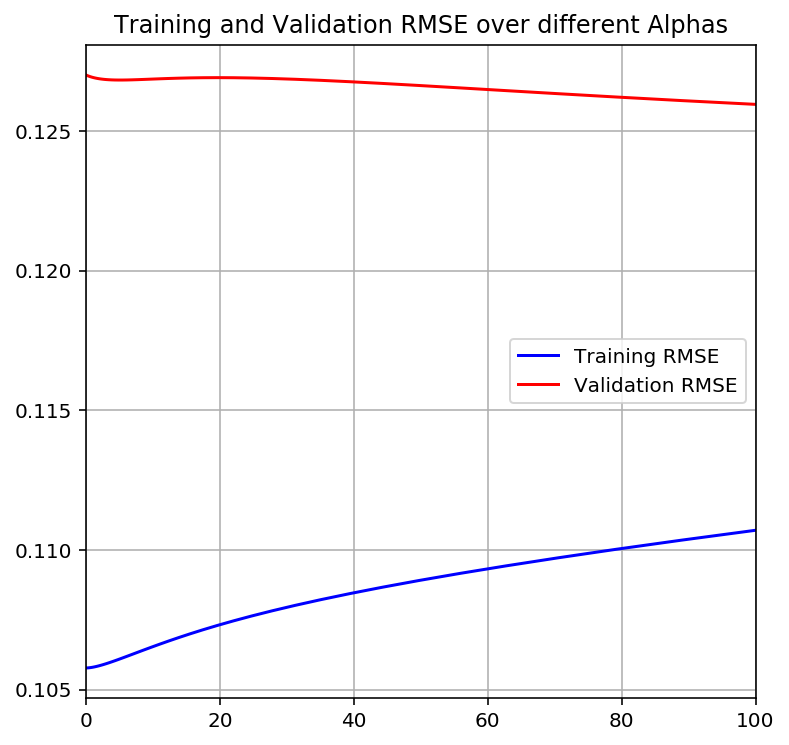

In [19]:
ridge_alpha_plots(alpha_vector, X_train, y_train, X_valid, y_valid)

In [84]:
alpha_vector = np.linspace(0,100,100)

In [94]:
rmse_ridge = []
rmse_ridge_train = []

for alpha in alpha_vector:
    ridge_pipe = Pipeline(steps=[('Standardise', StandardScaler()),
                                 ('Ridge', Ridge(alpha=alpha, random_state=SEED))
                                ])
    model = ridge_pipe.fit(X_train, y_train)
    resid = y_valid - model.predict(X_valid)
    rmse = np.sqrt(np.mean(resid**2))
    rmse_ridge.append(rmse)
    
    train_resid = y_train - model.predict(X_train)
    rmse_train = np.sqrt(np.mean(train_resid**2))
    rmse_ridge_train.append(rmse_train)

In [95]:
ridge_rmse_scores = pd.Series(rmse_ridge, index=alpha_vector)
train_ridge_rmse_scores = pd.Series(rmse_ridge_train, index=alpha_vector)

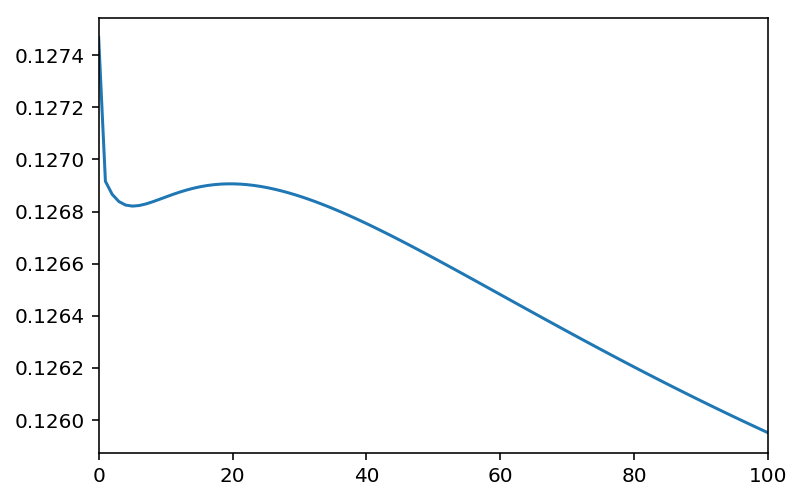

In [97]:
ridge_rmse_scores.plot()

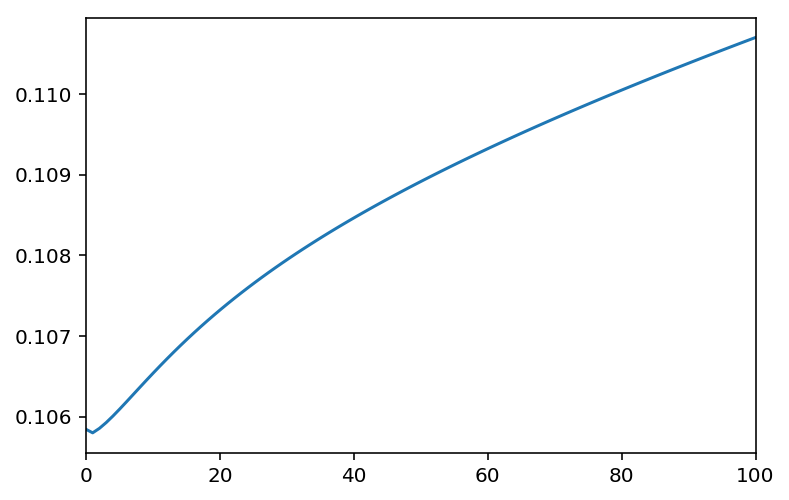

In [98]:
train_ridge_rmse_scores.plot()

In [99]:
lasso_pipe = Pipeline(steps=[('Standardise', StandardScaler()),
                             ('Lasso', Lasso(random_state=SEED)
                             )])

In [57]:
ridge_rmse_scores.nsmallest(n=1).index

Float64Index([0.001], dtype='float64')

In [137]:
alpha_vector = np.linspace(0,0.1,101)

In [139]:
lasso_pipe = Pipeline(steps=[('Standardise', StandardScaler()),
                             ('Lasso', Lasso(random_state=SEED)
                             )])

parameters_lasso = {'Lasso__alpha' : alpha_vector,
                    'Lasso__fit_intercept' : [True, False]}

gscv_lasso = GridSearchCV(lasso_pipe, parameters_lasso, n_jobs=-1,
                          scoring='neg_mean_squared_error', verbose=False, cv=5)

gscv_lasso_model = gscv_lasso.fit(X_train, y_train)

gscv_lasso_model.best_params_

In [140]:
gscv_lasso = GridSearchCV(lasso_pipe, parameters_lasso, n_jobs=-1,
                          scoring='neg_mean_squared_error', verbose=False, cv=5)

In [141]:
gscv_lasso_model = gscv_lasso.fit(X_train, y_train)

In [142]:
gscv_lasso_model.best_params_

{'Lasso__alpha': 0.003, 'Lasso__fit_intercept': True}